# Importing Libraries & Collecting data

In [1]:
# import all neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pickle
from tqdm import tqdm


%matplotlib inline
rcParams['figure.figsize'] = 9,7

In [2]:
# Collecting data.

print("Reading user-item-interactions.csv...")
df = pd.read_csv('user-item-interactions.csv')
del df['Unnamed: 0']
print('done')
print("Reading articles_community.csv...")
df_content = pd.read_csv('articles_community.csv')
del df_content['Unnamed: 0']
print('done')

Reading user-item-interactions.csv...
done
Reading articles_community.csv...
done


In [3]:
#Viewing the head of the Data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

### Get to know about the data and perform neccessary data wrangling and data cleaning in the datasets

In [5]:
print("\nShape of the user-items-interactions df is:",df.shape)
print('\nShape of the articles-community df is',df_content.shape)


Shape of the user-items-interactions df is: (45993, 3)

Shape of the articles-community df is (1056, 5)


##### `1.` We will now see what is the distribution of how many articles a user interacts with in the dataset?

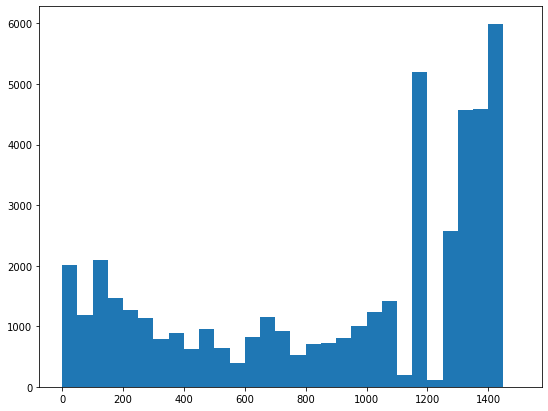

In [6]:
bins = np.arange(df['article_id'].min(),df['article_id'].max()+100,50)
plt.hist(df['article_id'],bins = bins);

In [7]:
# Statistics Description
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


##### The maximum number of user-article interactions by any 1 user ?

In [8]:
# maximum views by single user of the article
max_view_byuser = df['email'].value_counts()
max_view_byuser[0]

364

#### We will now explore and remove duplicate articles from the df_content dataframe.

In [9]:
print("Summary of our dataset ")
print("-"*115)


# maximum views by single user of the article
max_view_byuser = df['email'].value_counts()
print("\nThe maximum number of user-article interactions by any 1 user:",max_view_byuser[0])

# we will now code to remove duplicates in the dataset df_content

print('\nNumber of duplicate articles: {}'.format(df_content.duplicated('article_id').sum()))
 
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id', keep='first')
print('\nShape of the articles-community df after removing Duplicates:',df_content.shape[0])


# The number of unique articles that have an interaction with a user.
unique_articles = df['article_id'].nunique()
print('\nThe number of unique articles that have an interaction with a user:',unique_articles)


# The number of unique articles on the IBM platform
total_article = df_content['article_id'].nunique()
print('\nThe number of unique articles on the IBM platform:',total_article)


# The number of unique users
unique_users = df['email'].nunique()
print('\nThe number of unique users:',unique_users)


# The most viewed article in the dataset
most_viewed_article = df['article_id'].value_counts()
print('\nThe no.of times most viewed article is viewed:',most_viewed_article.tolist()[0])

Summary of our dataset 
-------------------------------------------------------------------------------------------------------------------

The maximum number of user-article interactions by any 1 user: 364

Number of duplicate articles: 5

Shape of the articles-community df after removing Duplicates: 1051

The number of unique articles that have an interaction with a user: 714

The number of unique articles on the IBM platform: 1051

The number of unique users: 5148

The no.of times most viewed article is viewed: 937


In [10]:
# this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

###### This function below will return the **n** top articles ordered with most interactions as the top. 

In [11]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts()
    top_articles = pd.DataFrame(top_articles).reset_index()
    top_articles = top_articles.drop('title',axis = 1)
    top_articles = top_articles['index'].tolist()
    top_articles = top_articles[:n]
    
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_id(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_article_id = df['article_id'].value_counts()
    top_article_id = pd.DataFrame(top_article_id).reset_index()
    top_article_id = top_article_id.drop('article_id',axis = 1)
    top_article_id = top_article_id['index'].tolist()
    top_article_id = top_article_id[:n]
 
    return top_article_id # Return the top article ids

In [12]:
print(get_top_articles(10))
print(get_top_article_id(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [65]:
top_5 = get_top_articles(5)
print('Top 5 articles:',top_5)

top_10 = get_top_articles(10)
print('\nTop 10 articles :',top_10)

top_20 = get_top_articles(20)
print('\nTop 20 articles :',top_20)

Top 5 articles: ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']

Top 10 articles : ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']

Top 20 articles : ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis',

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [13]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    df_new=df.groupby(['article_id', 'user_id']).count().reset_index()
    df_new=df_new.pivot_table(index='user_id',columns='article_id',values='title')
    df_new = df_new.replace(np.nan, 0)
    user_item=df_new.applymap(lambda x: 1 if x > 0 else x)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [14]:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [15]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_prod_users = user_item.dot(user_item.transpose())
    # sort by similarity and remove the own user's id
    similar_user_matrix = dot_prod_users.sort_values(user_id, ascending=False).drop(user_id, axis=0)
    # create list of just the ids
    most_similar_users = similar_user_matrix[user_id].index.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [16]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


3. Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend. Complete the functions below to return the articles you would recommend to each user.

In [17]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    unique_df = df.drop_duplicates('article_id')
    select_title = unique_df['title'][unique_df['article_id'].isin(article_ids)]
    article_names = list(select_title)
    
    return article_names # Return the article names associated with list of article ids

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    transpose_df = user_item.transpose()
    select_article_ids = transpose_df[transpose_df[user_id] == 1].index
    article_ids = list(select_article_ids)
    article_ids=[str(s) for s in article_ids]
    article_names_list = get_article_names(article_ids)

    return article_ids, article_names_list # return the ids and names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # Find all articles that the user has read before
    
    import itertools
    user_read_articles = get_user_articles(user_id)[0]
    similar_users = find_similar_users(user_id)

    # Find all articles that has been read by the similiar users
    read_articles = [get_user_articles(user)[0] for user in similar_users]
    read_articles_list = list(itertools.chain.from_iterable(read_articles))

    # remove duplicated read articles
    read_articles_unique = pd.Series(read_articles_list).drop_duplicates().tolist()

    # remove articles that has been seen by the given user, use the remaining articles as recommendations
    recs = [i for i in read_articles_unique if i not in user_read_articles][:m]   
    
    return recs

    # return your recommendations for this user_id 

In [18]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [19]:
get_article_names(user_user_recs(1, 10))

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [20]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    
    for user in user_item.index:
        
        # ignore if is the user being analysed
        if user == user_id:
            continue
        
        # insert a new register with the user_id as the index
        # user is the neighbor, the dot product calculates the similarity between the two users, 
        # and the number of articles user interacted with
        neighbors_df.loc[user] = [user, np.dot(user_item.loc[user_id, :], user_item.loc[user, :]),
                                  df[df['user_id']==user]['article_id'].count()]
    
    # dataframe is sorted first by the similarity between the users and later by the number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = []
    
    neighbors_df = get_top_sorted_users(user_id)

    # get the user articles
    user_articles, the_article_names = get_user_articles(user_id)
    
    # go through every neighbor and every article of this neighbor and if user has not seen
    # the article add it to the list
    for user in neighbors_df['neighbor_id']:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in user_articles:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break

    if len(recs) < m:
        for id in [str(id) for id in get_top_article_ids(100)]:
            if id not in user_articles:
                recs.append(id)
            if len(recs) >= m:
                    break
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names



In [21]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(1, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['2.0', '12.0', '14.0', '16.0', '26.0', '28.0', '29.0', '33.0', '50.0', '74.0']

The top 10 recommendations for user 20 are the following article names:
['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'graph-based machine learning', 'using brunel in ipython/jupyter notebooks', 'experience iot with coursera', 'the 3 kinds of context: machine learning and the art of the frame', 'deep forest: towards an alternative to deep neural networks', 'this week in data science (april 18, 2017)', 'higher-order logistic regression for large datasets', 'using machine learning to predict parking difficulty']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [22]:
# quick look at the matrix
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

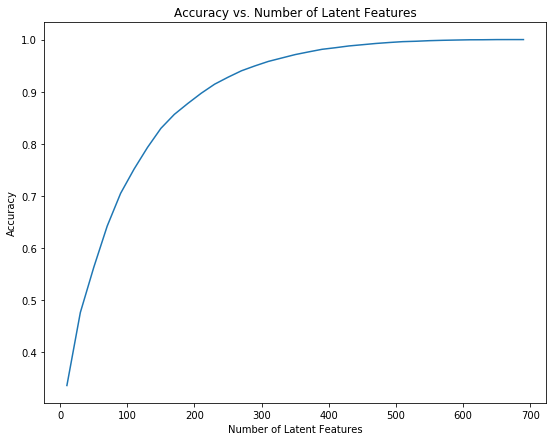

In [25]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [54]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    #train user_item_matrix
    
    user_item_train = create_user_item_matrix(df_train)
    
    #test user_item_matrix
    
    user_item_test = create_user_item_matrix(df_test)
    
    
    #all of the test user ids
    
    test_idx = list(user_item_test.index.values)
    
    #all of the test article ids
    
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [55]:
# List for train & test data - rows and columns values
# The rows to be used for test--
train_idx = set(user_item_train.index)
test_idx = set(user_item_test.index)
common_rows = train_idx.intersection(test_idx)

# # The columns to be used for tets --
train_arts = set(user_item_train.columns)
test_arts = set(user_item_test.columns)
common_cols = train_arts.intersection(test_arts)

# # Creating new user-item matrix for tets with common values
user_item_test = user_item_test.loc[common_rows, common_cols]

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [56]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [58]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

In [59]:
"""
 1 Build the test SVD matrix.
 2 remove test users with cold start issue
 3 draw a curve of latent factors number vs accuary rate
"""

num_latent_feats = np.arange(10, 700+10, 20)
sum_errs_train = []
sum_errs_test = []
all_errs = []

for k in num_latent_feats:
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # dot product:
    user_item_train_pred = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_pred = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    all_errs.append(1 - ((np.sum(user_item_test_pred) 
                          + np.sum(np.sum(user_item_test)))
                         / (user_item_test.shape[0] * user_item_test.shape[1])))
    
    # Calculate the error of each prediction with the true value
    diff_train = np.subtract(user_item_train, user_item_train_pred)
    diff_test = np.subtract(user_item_test, user_item_test_pred)
    
    # Total Error
    error_train = np.sum(np.sum(np.abs(diff_train)))
    error_test = np.sum(np.sum(np.abs(diff_test)))
    
    sum_errs_train.append(error_train)
    sum_errs_test.append(error_test)

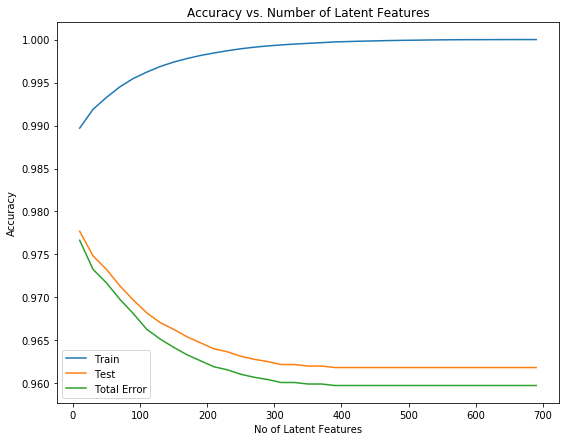

In [60]:
# Plot Accuracy for Train and Test VS Latent num of features

plt.plot(num_latent_feats, 
         1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]),
         label='Train')

plt.plot(num_latent_feats,
         1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]),
         label='Test')

plt.plot(num_latent_feats, all_errs, label='Total Error')
plt.xlabel('No of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

According to the experiment above, the accuracy decreases when the number of latent features increases, causing overfitting. In the data used, the common users between the train and test set are too few, only 20, and rest major part 600+ users were with no inetractions. Therefore, we have to solve the cold-start problem. To do that we could use other recommendation methods to improve our recommendation like rank based recommendation method and content based recommendation can be handy for users with fewer inetractions. A/B can the used to avaliate how well our recommendation engine is working in practice to further engage users. The test can be built by randomly separating two groups of users, one uing our recommendation engine and the other using random recommendation, to keep aside biasness factor. Different hypothesis can be performed with the users data group, for example, compare the hit rate of the recommendation articles to measure if our recommendation engine increases the view count. If it is significant, we can conclude that our recommendation engine works well.